In [57]:
%matplotlib inline

import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

#### Globals

In [131]:
PATH_PIPE = '../Pipeline/'
PATH_RAW = '../data/raw_data/'
PATH_DATA = '../data/data/'
PATH_MODELS = '../../models/'
PATH_IMAGES = '../assets/images/'

MULTICLASS = ['Not constructive', 'Rather not', 'Rather yes', 'Constructive']
BINARY = ['Not constructive', 'Constructive']
MULTICLASS_NUM = [0, 1, 2, 3]
BINARY_NUM = [0, 1]

MODEL_NAME = 'distilbert-base-uncased'
MAXLEN = 250
MAXFEATURES = 5000
BATCH_SIZE = 6

## Load data

Either with separate train and test files or...

In [99]:
train = pd.read_csv(PATH_DATA + "2829_train.csv")
test = pd.read_csv(PATH_DATA + "2829_test.csv")

X, y, y_bin = train['text_review'], train['tag'], train['bin_tag']
X_test, y_test, y_bin_test = test['text_review'], test['tag'], test['bin_tag']

X_train, X_val, y_train, y_val = train_test_split(X, y_bin, test_size=0.1, random_state=42)

... with only one file.

In [110]:
data = pd.read_csv(PATH_DATA + "2840_full_data.csv")

# Prevent missing values
data = data.dropna(subset=['tag'])

X, y, y_bin = data['text_review'], data['tag'], data['bin_tag']

X_train, X_test, y_train, y_test =  [np.asarray(x) for x in train_test_split(X, y_bin, test_size=0.25, random_state=42)]
X_train, X_val, y_train, y_val = [np.asarray(x) for x in train_test_split(X_train, y_train, test_size=0.1, random_state=42)]


## Load model and preprocess

In [117]:
# Setup the text transformer from ktrain
t = text.Transformer(MODEL_NAME, maxlen=MAXLEN, class_names=BINARY)

# Special preprocessing step
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_val, y_val)

# Model generation
model = t.get_classifier()

preprocessing train...
language: en
train sequence lengths:
	mean : 66
	95percentile : 230
	99percentile : 540


preprocessing test...
language: en
test sequence lengths:
	mean : 60
	95percentile : 199
	99percentile : 374


We get a Learner object that wraps training, tuning and validating

In [118]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

## Training and tuning

Tries different learning rates for pre-tuning

simulating training for different learning rates... this may take a few moments...
Train for 318 steps
318/318 [==============================] - 1271s 4s/step - loss: 0.9005 - accuracy: 0.5425


done.


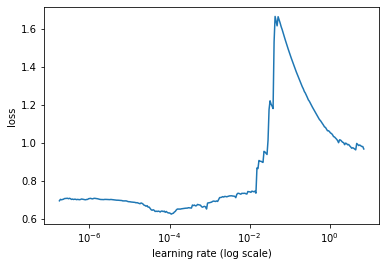

In [119]:
learner.lr_find(show_plot=True, max_epochs=1)

#### Training

`fit_onecycle` gradually increases the learning rate for half of the training and then decreases it until the end.

`fit` is used with SGDR learning rate schedule.

`autofit` uses a triangular learning rate policy

In [120]:
learner.fit_onecycle(7e-5, 3)

#learner.fit(0.001, 3, cycle_len=1, cycle_mult=2)

#learner.autofit(0.001, 1)



begin training using onecycle policy with max lr of 7e-05...
Train for 318 steps, validate for 7 steps
Epoch 1/3
318/318 [==============================] - 1392s 4s/step - loss: 0.5385 - accuracy: 0.7463 - val_loss: 0.4307 - val_accuracy: 0.7793
Epoch 2/3
318/318 [==============================] - 1239s 4s/step - loss: 0.3854 - accuracy: 0.8438 - val_loss: 0.4906 - val_accuracy: 0.7746
Epoch 3/3
318/318 [==============================] - 1189s 4s/step - loss: 0.1423 - accuracy: 0.9539 - val_loss: 0.5944 - val_accuracy: 0.7793


Checking which _n_ samples induced the strongest loss.

In [121]:
learner.top_losses(n=10, preproc=t)

[(139, 4.571482, 'Not constructive', 'Constructive'),
 (37, 4.5341554, 'Not constructive', 'Constructive'),
 (0, 4.529791, 'Not constructive', 'Constructive'),
 (72, 4.4601064, 'Not constructive', 'Constructive'),
 (153, 4.43575, 'Not constructive', 'Constructive'),
 (24, 4.3518715, 'Not constructive', 'Constructive'),
 (154, 4.3340993, 'Not constructive', 'Constructive'),
 (86, 4.286712, 'Not constructive', 'Constructive'),
 (133, 4.283191, 'Not constructive', 'Constructive'),
 (36, 4.266737, 'Not constructive', 'Constructive')]

Validate on validation data. Outputs an sklearn classification report.

In [122]:
learner.validate(class_names=t.get_classes())

                  precision    recall  f1-score   support

Not constructive       0.85      0.66      0.74       103
    Constructive       0.74      0.89      0.81       110

        accuracy                           0.78       213
       macro avg       0.79      0.78      0.77       213
    weighted avg       0.79      0.78      0.78       213



array([[68, 35],
       [12, 98]])

Loading a trained model

In [ ]:
#predictor = ktrain.load_predictor(PATH_MODELS + model_name)

## Prediction

In [30]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

#### On the SFU OCC corpus (binary classification only)

In [34]:
new_data = pd.read_csv(PATH_DATA + 'SOCC.csv')
new_data = new_data.loc[:, ['comment_text', 'is_constructive']]
new_data['is_constructive'] = new_data.loc[:, 'is_constructive'].map({'no': 'Not Constructive',
                                                                      'yes': 'Constructive'})

X_new, y_new = np.asarray(new_data['comment_text']), np.asarray(new_data['is_constructive'])

In [125]:
#predictor.predict(data, return_proba=True)
y_pred = predictor.predict(X_test)

In [ ]:
y_pred

In [128]:
y_new_corr = ['Constructive' if x == 1 else 'Not constructive' for x in y_test]

In [137]:
print("Accuracy:", accuracy_score(y_new_corr, y_pred))
print("F1 Score:", f1_score(y_new_corr, y_pred, average='weighted'))
report = classification_report(y_new_corr, y_pred, output_dict=True)
print(classification_report(y_new_corr, y_pred))

Accuracy: 0.8107344632768362
F1 Score: 0.808132023420109
                  precision    recall  f1-score   support

    Constructive       0.78      0.90      0.84       380
Not constructive       0.86      0.70      0.78       328

        accuracy                           0.81       708
       macro avg       0.82      0.80      0.81       708
    weighted avg       0.82      0.81      0.81       708



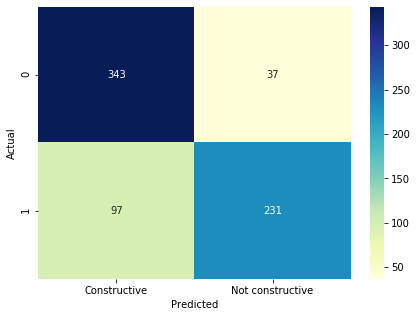

In [130]:
conf_mat = confusion_matrix(y_new_corr, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

ax.set_xticklabels(['Constructive', 'Not constructive'])

plt.show()

fig.savefig(PATH_IMAGES + "Distilbert_1_epoch_SOCC.png", dpi=300, quality=95, format='png', bbox_inches='tight')

#### Saving the model

In [31]:
predictor.save(PATH_MODELS + 'distilbert_1_epoch')

Visualize the weight of words in classification (not workng on Colab)

In [63]:
#!pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /private/var/folders/l5/nffr1ly16_xb_5mt_4fng4zr0000gn/T/pip-req-build-ctaal_ab
  Running command git clone -q https://github.com/amaiya/eli5 /private/var/folders/l5/nffr1ly16_xb_5mt_4fng4zr0000gn/T/pip-req-build-ctaal_ab
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.
  Using cached graphviz-0.13.2-py2.py3-none-any.whl (17 kB)
  Using cached tabulate-0.8.7-py3-none-any.whl (24 kB)
  Created wheel for eli5: filename=eli5-0.10.1-py2.py3-none-any.whl size=106682 sha256=4b52f3dedc9c3e058d4a6b387980c74a9f3150d37c64259b1fedd7d1e965dcb4
  Stored in directory: /private/var/folders/l5/nffr1ly16_xb_5mt_4fng4zr0000gn/T/pip-ephem-wheel-cache-kjhfgjfb/wheels/93/23/c2/479f99e6e981887ac70af72d4ff763471acf7184d1b80a9268
Successfully built eli5
You should consider upgra

In [64]:
predictor.explain("This is a very nice dress")